# 몬테카를로 시뮬레이션(Monte Carlo Simulation)
- 몬테카를로 시뮬레이션에 대해서 알아보겠습니다.

In [28]:
import numpy as np
import pandas as pd
#from pylab import mpl, plt
import matplotlib.pyplot as plt
import yfinance as yf
#import FinanceDataReader as fdr

## 1. VaR(Value at Risk)
- 측정하는 방법은 3가지가 있습니다.
    1. 전통적 방법
    - 수익률을 구하고, 분포를 그린 다음 분석하는 것
    2. Delta Normal
    - 정규분포를 이룬다는 가정하에 분석
    3. 시뮬레이션 분석
    - 기하브라운모형으로 모델링을 한 후, 몬테카를로 시뮬레이션을 통해 검증
    - 기하브라운모형으로 모델링하기 때문에 로그 수익률은 정규분포를 따른다는 가정이 있어야 합니다.

In [29]:
# 미국의 10대 ETF 데이터 불러오기
tickers =['SPY', 'QQQ', 'VOO', 'IWM', 'VTI', 'GLD', 'AGG', 'XLF', 'XLK', 'VNQ']
raw = yf.Tickers(tickers)
data = raw.history(start="2000-01-01", end="2019-12-31").Close
data.head()

[*********************100%***********************]  10 of 10 completed


,AGG,GLD,IWM,QQQ,SPY,VNQ,VOO,VTI,XLF,XLK
Date,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,81.233719,94.595085,NaN,NaN,NaN,11.589030,42.028297
2000-01-04,NaN,NaN,NaN,75.661018,90.895836,NaN,NaN,NaN,11.082401,39.896069
2000-01-05,NaN,NaN,NaN,73.731956,91.058388,NaN,NaN,NaN,10.995333,39.303806
2000-01-06,NaN,NaN,NaN,68.668228,89.595009,NaN,NaN,NaN,11.478209,38.000790
2000-01-07,NaN,NaN,NaN,77.161339,94.798332,NaN,NaN,NaN,11.668189,38.664146


In [30]:
# GLD 를 예시로 들어볼까요?
# 일별 수익률 조회
GLD_rtn = data['GLD'].copy().pct_change().dropna()
GLD_rtn.head()

Date
2004-11-19    0.009013
2004-11-22    0.003796
2004-11-23   -0.004449
2004-11-24    0.006704
2004-11-26    0.005327
Name: GLD, dtype: float64

In [31]:
# VaR 계산
GLD_VaR = GLD_rtn.quantile(0.05)
print(f"VaR of GLD = {GLD_VaR:.5f}")

VaR of GLD = -0.01781


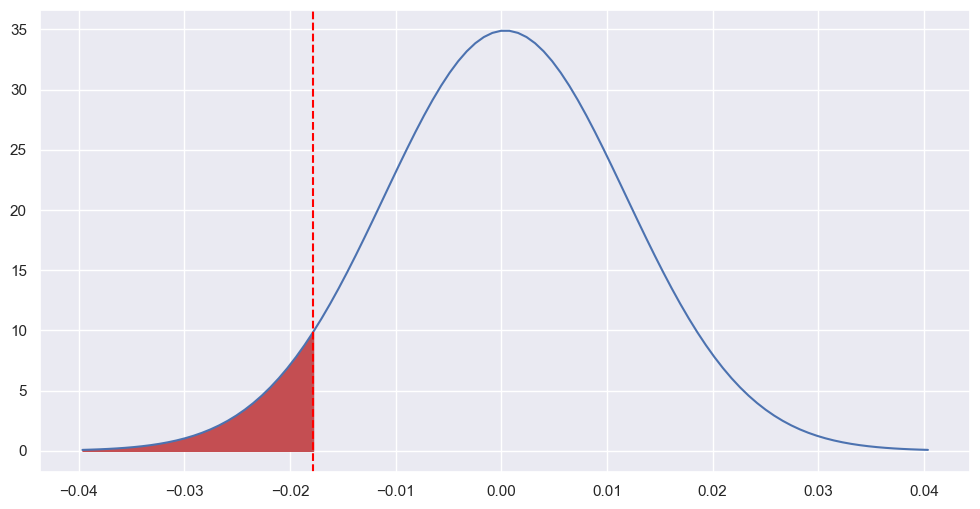

In [32]:
import scipy.stats as stats

mu = GLD_rtn.mean() # 평균
sigma = GLD_rtn.std() # 표준편차

x = np.linspace(mu - 3.5 * sigma, mu + 3.5 * sigma, 100)
y = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.fill_between(x, y, where = x <= GLD_VaR, color='r')
plt.axvline(GLD_VaR, color='red', linestyle='--', label='VaR')
plt.show()

### Q1. 위 그래프는 무엇을 의미할까요?
- #### Q1-1. 여러분들의 종목으로 해보세요.

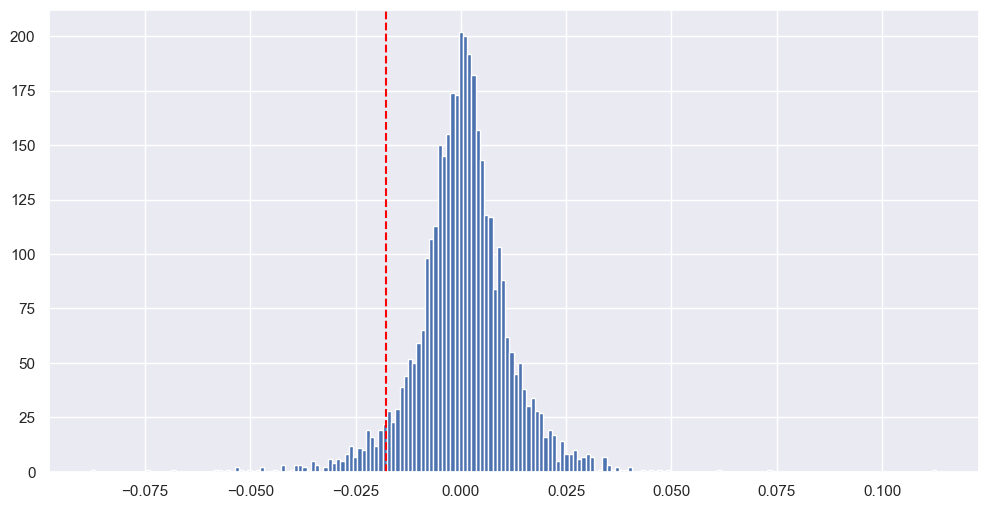

In [33]:
# 히스토그램으로 표현 (정규성 가정x)
plt.figure(figsize=(12,6))
plt.hist(GLD_rtn, bins=200)
plt.axvline(GLD_VaR, color='red', linestyle='--', label='VaR')

- 그러나 이는 특정 확률 이상의 손실을 고려하지 않습니다.
- 이러한 단점을 보완하기 위해 CVaR(Conditional Value at Risk)와 같은 다른 위험 측정 지표가 사용됩니다.

## 2. CVaR(Conditional Value at Risk)
> - CVaR : VaR이 어떤 확률로 발생할 수 있는 최대 손실을 나타낸다면 CVaR은 VaR 초과 손실의 평균을 나타낸다. CVaR은 보다 더 극단적인 위험을 측정할 수 있다.

In [34]:
# 일별 수익률 조회
GLD_rtn = data['GLD'].copy().pct_change().dropna()

# CVaR 계산
GLD_CVaR = GLD_rtn[GLD_rtn <= GLD_VaR].mean()
print(f"CVaR of GLD = {GLD_CVaR:.5f}")

CVaR of GLD = -0.02707


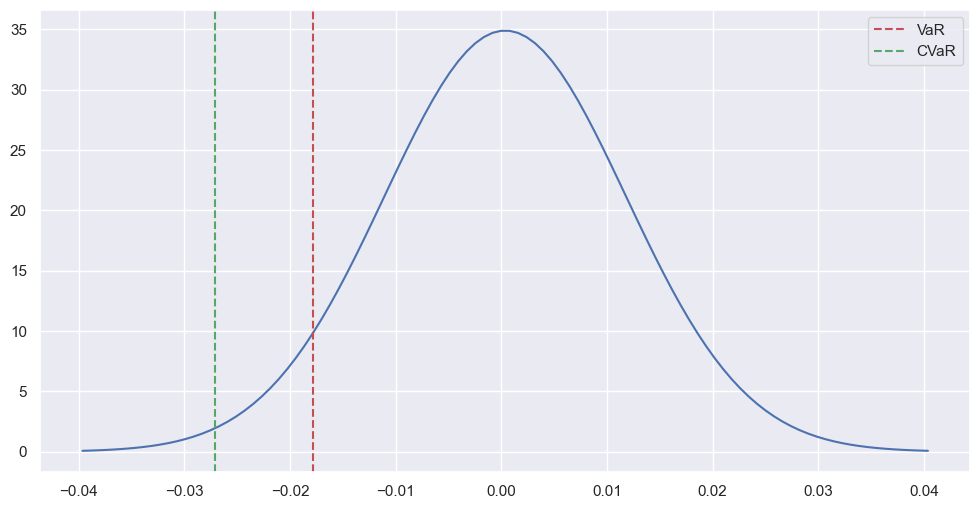

In [35]:
mu = GLD_rtn.mean() # 평균
sigma = GLD_rtn.std() # 표준편차

x = np.linspace(mu - 3.5 * sigma, mu + 3.5 * sigma, 100)
y = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.axvline(GLD_VaR, color='r', linestyle='--', label='VaR')
plt.axvline(GLD_CVaR, color='g', linestyle='--', label='CVaR')
plt.legend()
plt.show()

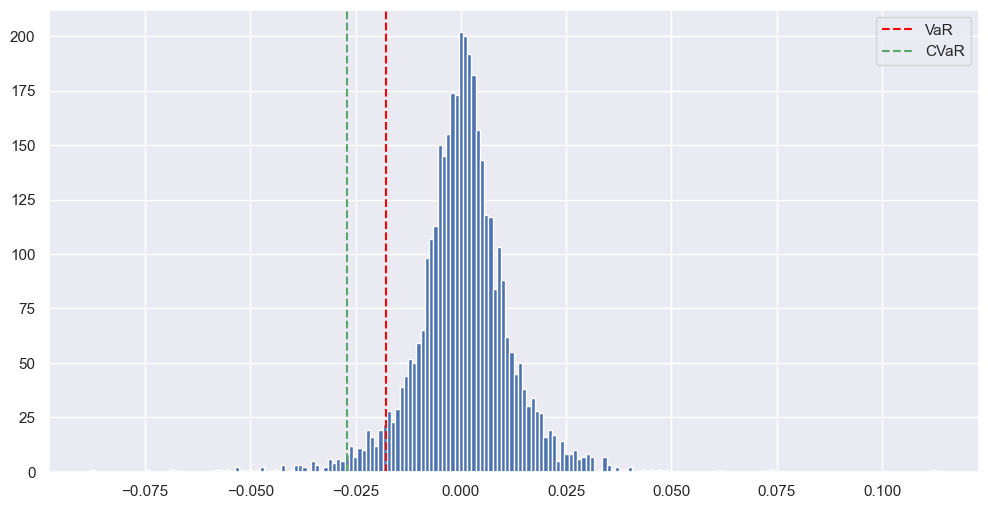

In [36]:
# 히스토그램으로 표현 (정규성 가정x)
plt.figure(figsize=(12,6))
plt.hist(GLD_rtn, bins=200)
plt.axvline(GLD_VaR, color='red', linestyle='--', label='VaR')
plt.axvline(GLD_CVaR, color='g', linestyle='--', label='CVaR')
plt.legend();

- 언뜻 보기에도 CVaR이 더 작은 값임을 알 수 있습니다.

- 점선 아래의 데이터들은 어떤 분포를 가지고 있을지, 확대해 보겠습니다.

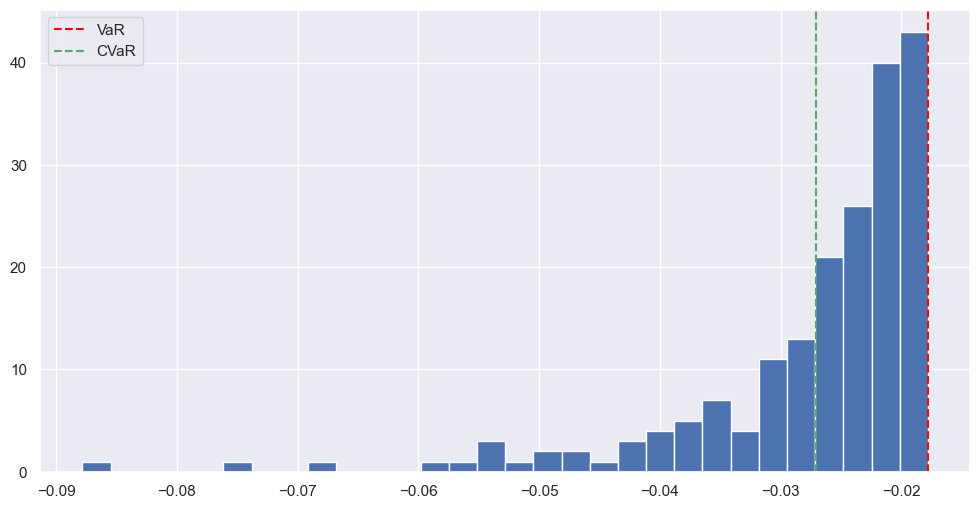

In [37]:
plt.figure(figsize=(12,6))
plt.hist(GLD_rtn[GLD_rtn <= GLD_VaR], bins=30)
plt.axvline(GLD_VaR, color='red', linestyle='--', label='VaR')
plt.axvline(GLD_CVaR, color='g', linestyle='--', label='CVaR')
plt.legend();

## 3. 몬테카를로 시뮬레이션
- 시뮬레이션을 통해 난수를 생성하고, 해당 분포에서 VaR과 CVaR을 구해봅시다.

### 주가 모델링 : 기하 브라운 모델

$$S_T = S_0e^{(r-\frac{\sigma^2}{2})*T + \sigma \sqrt{T}Z}$$

- $S_T$ : T시점 이후의 주가
- $S_0$ : 현재 시점의 주가
- $r$ : 무위험 이자율
- $\sigma$ : 주가변동성
- $T$ : 미래 시점까지의 시간
- $Z$ : 표준정규분포로부터 나온 난수

- 시간에 따라 가격이 어떻게 변하는지를 나타내며 주식의 가격이 로그 정규 분포를 따르는 것을 보여줍니다.
- 주식의 가격이 항상 양수이며, 주가의 변동이 주가의 크기에 비례한다는 사실을 반영하고 있습니다.

- 주식 가격의 불확실성과 위험성을 반영하며, 금융 공학에서 옵션 가격 결정, 위험 관리 등에 활용됩니다. 이는 블랙-숄즈 옵션 가격 결정 모델의 기반을 이룹니다.

In [38]:
import seaborn as sns
sns.set()
from scipy.stats import norm, uniform
import random

In [39]:
# GLD 불러오기
GLD = data['GLD']

# GLD 수익률 산출
GLD_rtn = GLD.pct_change().dropna()

# 평균 수익률
GLD_mu = GLD_rtn.mean()

# 표준편차
GLD_sigma = GLD_rtn.std()

# 시뮬레이션 기간
T = 1

# 현재 주가
S_0 = GLD.iloc[-1]

# 반복 일수
Nday = 1000

# 반복 횟수
Nsimulation = 10000

mcs = []

for _ in range(Nsimulation): # simulation 만큼 반복 (index의 수)
    S_0 = GLD.iloc[-1]
    rec = [S_0]
    
    for i in range(Nday): # day일 동안의 주가 (column의 수)
        S_0 = S_0 * np.exp((mu - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * random.normalvariate(0,1))
        rec.append(S_0)
        
    mcs.append(rec)

In [40]:
# 우리가 원하는 것은 시뮬레이션 1회 당 생성되는 난수들.
pd.DataFrame(mcs)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,142.630005,140.128062,139.940703,142.312266,144.165547,140.712344,139.843142,140.732192,141.359324,140.985169,...,153.318548,150.212461,152.061165,150.777669,150.197501,147.277370,148.209554,144.931573,144.502796,143.721186
1,142.630005,142.810828,142.853549,145.333561,147.077231,146.888725,143.954862,142.268122,143.694142,142.706470,...,146.050250,145.995709,144.050318,144.866871,147.437544,145.640902,143.434088,143.293877,143.130636,143.876539
2,142.630005,139.873546,139.296407,139.426435,141.079636,140.376600,140.719857,140.894313,141.913533,144.165286,...,142.353061,143.536908,141.107945,144.484547,146.216262,145.720343,148.183167,146.879055,148.630279,146.975597
3,142.630005,140.762046,142.069889,141.086851,141.425042,140.650617,139.056141,141.971955,144.069036,145.089812,...,175.237445,176.277834,178.770132,180.406120,178.173502,180.219649,178.157792,179.293707,178.222517,178.531983
4,142.630005,140.870172,142.179193,144.096880,143.989274,145.553101,145.138687,144.433889,142.348291,141.644982,...,216.119549,219.856023,219.015428,222.363088,226.994717,228.705551,229.017619,227.941637,225.384416,225.503618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,142.630005,143.252347,144.737581,146.406929,146.270115,147.615047,144.526070,145.223480,147.542530,146.174634,...,126.231054,127.153541,126.742170,125.777486,126.848933,130.912168,131.984700,132.350364,133.483875,134.796551
9996,142.630005,143.853386,144.454241,147.510913,145.721326,143.122236,145.442773,146.198907,147.891515,147.159250,...,338.269606,336.651337,337.284468,335.810073,336.845302,333.899299,326.850992,329.376468,327.947155,319.477187
9997,142.630005,142.934167,147.101823,147.283082,147.312600,147.138997,149.303571,148.500593,150.135022,148.826801,...,283.076794,287.368302,290.999752,296.253565,295.720072,302.477027,301.276487,300.960181,305.480275,300.826637
9998,142.630005,146.013410,143.219920,145.100539,143.412399,144.185548,143.738490,143.187240,145.344851,144.905738,...,166.428787,164.241635,165.918695,167.329111,163.407083,163.834597,165.084999,168.287619,168.867768,168.774583


In [51]:
mcsT = pd.DataFrame(mcs).T

for i in range(len(mcsT.columns)):
    mcsT.rename(columns={i : f'Simulation #{i+1}'}, inplace=True)
    
mcsT

,Simulation #1,Simulation #2,Simulation #3,Simulation #4,Simulation #5,Simulation #6,Simulation #7,Simulation #8,Simulation #9,Simulation #10,...,Simulation #9991,Simulation #9992,Simulation #9993,Simulation #9994,Simulation #9995,Simulation #9996,Simulation #9997,Simulation #9998,Simulation #9999,Simulation #10000
0,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,...,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005,142.630005
1,140.128062,142.810828,139.873546,140.762046,140.870172,142.883092,143.808335,142.602963,142.278964,145.049851,...,143.254583,142.413778,141.889871,143.551853,142.702484,143.252347,143.853386,142.934167,146.013410,144.156423
2,139.940703,142.853549,139.296407,142.069889,142.179193,141.518426,144.466235,144.704078,143.174215,146.038332,...,143.061596,141.908845,143.245195,143.086569,140.760127,144.737581,144.454241,147.101823,143.219920,140.817444
3,142.312266,145.333561,139.426435,141.086851,144.096880,140.990379,143.355312,149.284231,141.470510,145.728918,...,146.040357,141.671373,142.516369,145.942601,139.062804,146.406929,147.510913,147.283082,145.100539,141.605653
4,144.165547,147.077231,141.079636,141.425042,143.989274,139.049267,142.813944,151.037169,141.375837,144.165397,...,146.671691,142.771201,141.191923,144.444082,138.389550,146.270115,145.721326,147.312600,143.412399,141.413311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,147.277370,145.640902,145.720343,180.219649,228.705551,239.049138,222.008885,239.668109,176.510883,123.507849,...,117.921726,193.516557,131.341926,160.422640,145.832958,130.912168,333.899299,302.477027,163.834597,200.042220
997,148.209554,143.434088,148.183167,178.157792,229.017619,246.563964,220.803508,240.932712,180.603039,124.530482,...,118.250366,193.829090,130.642583,163.452030,142.824115,131.984700,326.850992,301.276487,165.084999,200.133137
998,144.931573,143.293877,146.879055,179.293707,227.941637,245.280363,222.027823,241.592009,180.100325,125.407713,...,117.397629,196.659112,130.828223,166.439317,145.377902,132.350364,329.376468,300.960181,168.287619,198.490556
999,144.502796,143.130636,148.630279,178.222517,225.384416,245.798592,218.028543,241.254710,175.681444,124.035200,...,120.435975,196.205877,130.600187,168.202272,145.664287,133.483875,327.947155,305.480275,168.867768,196.296350


- 1일차(현재) 가격은 같은 지점에서 시작한다. 이후 난수가 생성되며 랜덤한 주가 데이터를 생성한다.

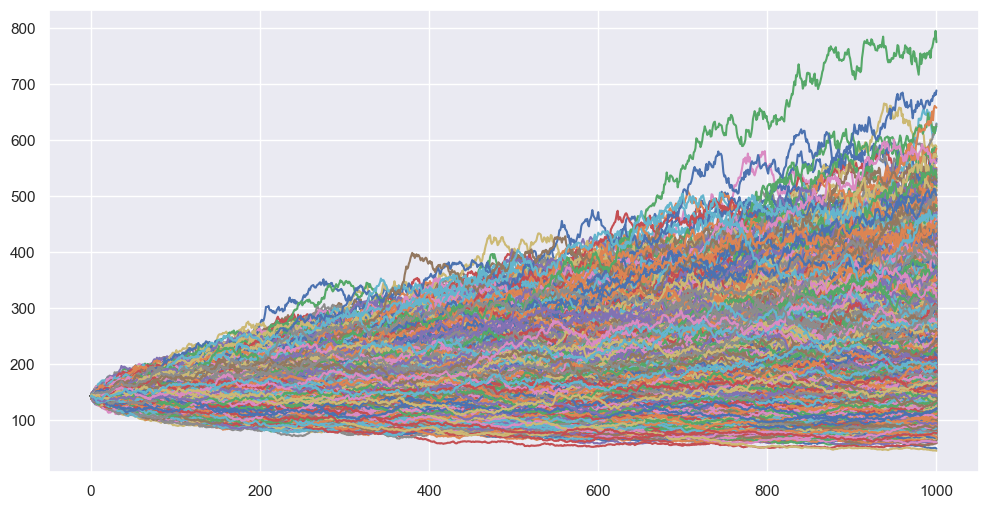

In [43]:
mcsT.plot(legend=None, figsize=(12,6));

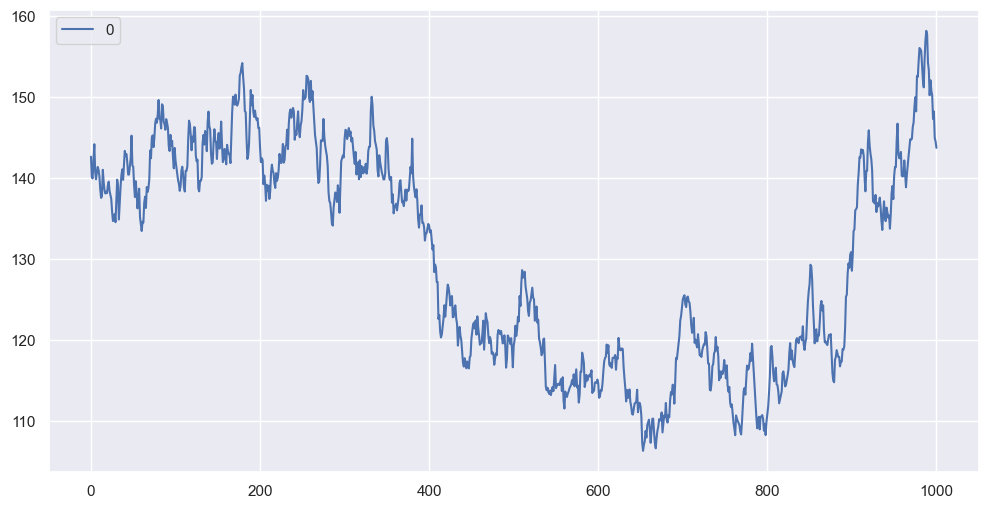

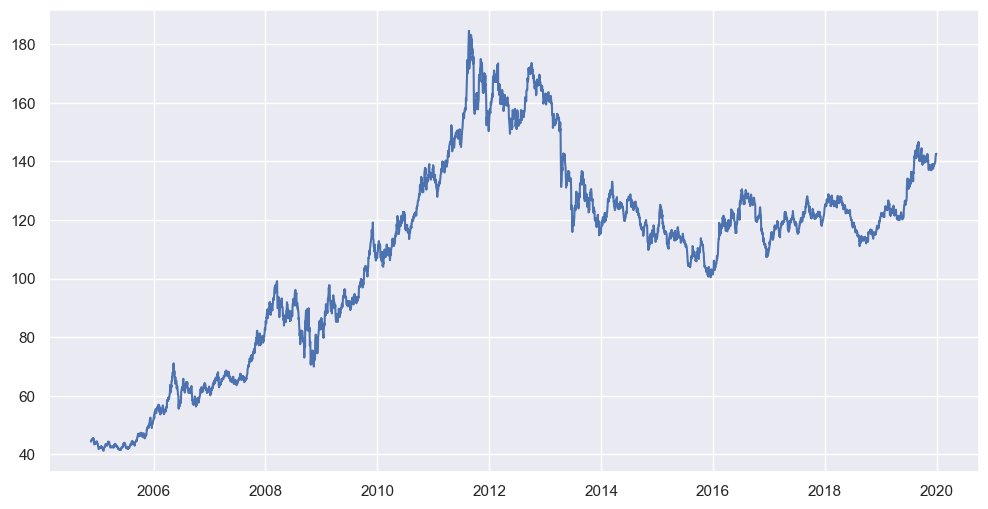

In [50]:
mcsT.iloc[:,0].plot(figsize=(12,6), legend=True);

plt.figure(figsize=(12,6))
plt.plot(data['GLD']);

In [ ]:
# T 시점 이후의 주가 계산 함수화
def S_T(S_0, mu, sigma, Z, T):
    return S_0 * np.exp((mu - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)

# 이번엔 SPY로 1년을 시뮬레이션 해보자.
SPY = data['SPY']

# 수익률
SPY_rtn = SPY.pct_change().dropna()

# 평균 수익률 (1년)
mu = SPY_rtn.mean() * 252

# 수익률의 표준 편차 (1년)
sigma = SPY_rtn.std() * np.sqrt(252)

# T = 1 : 1년
T = 0.25

# 시뮬레이션 횟수
Nsimulation = 10000

# VaR setting
delta = 0.01

# 처음 주가
S_0 = SPY.iloc[-1]

# 난수 생성 (1행 x 시뮬레이션 횟수)
Z = norm.rvs(size=[1, Nsimulation])

# Flatten을 하는 이유는?
S_T_ = pd.Series(S_T(S_0, mu, sigma, Z, T).flatten())

# 수익률 다시 갱신... 생성된 난수에서
SPY_rtn = (S_T_ - S_0) / S_0
SPY_rtn

0      -0.016448
1       0.116387
2      -0.103250
3      -0.038286
4       0.066257
          ...   
9995    0.041237
9996    0.072013
9997    0.129529
9998    0.046875
9999    0.129435
Length: 10000, dtype: float64

In [ ]:
SPY_VaR = SPY_rtn.quantile(delta) # 0.01
SPY_CVaR = SPY_rtn[SPY_rtn <= SPY_VaR].mean()

SPY_VaR, SPY_CVaR

(-0.19009809328169064, -0.21717415749006985)

In [ ]:
print(f"VaR: {SPY_VaR:.2f}, CVaR: {SPY_CVaR:.2f}")

VaR: -0.19, CVaR: -0.22


결과 해석?

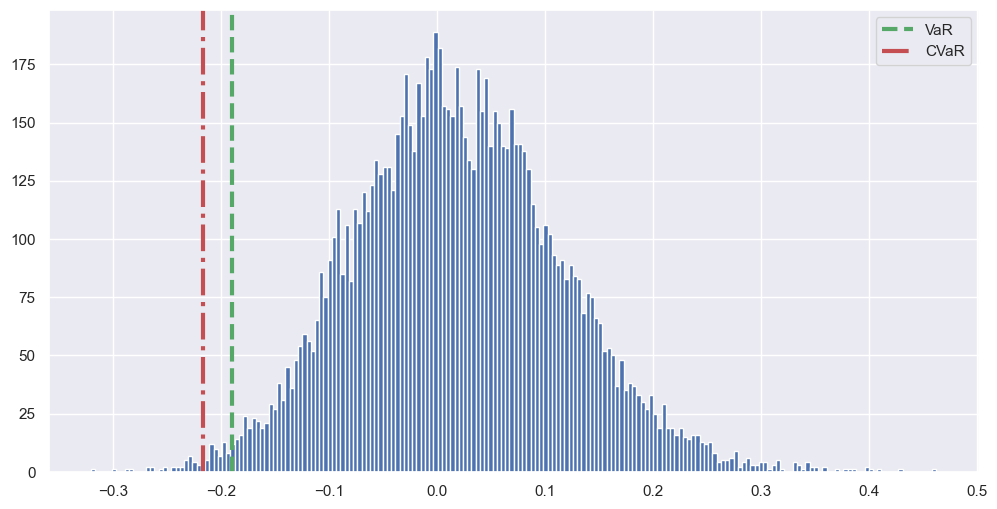

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(SPY_rtn, bins = 200)
plt.axvline(SPY_VaR, c='g', lw=3, linestyle='--', label = 'VaR')
plt.axvline(SPY_CVaR, c='r', lw=3, linestyle='-.', label = 'CVaR')
plt.legend();

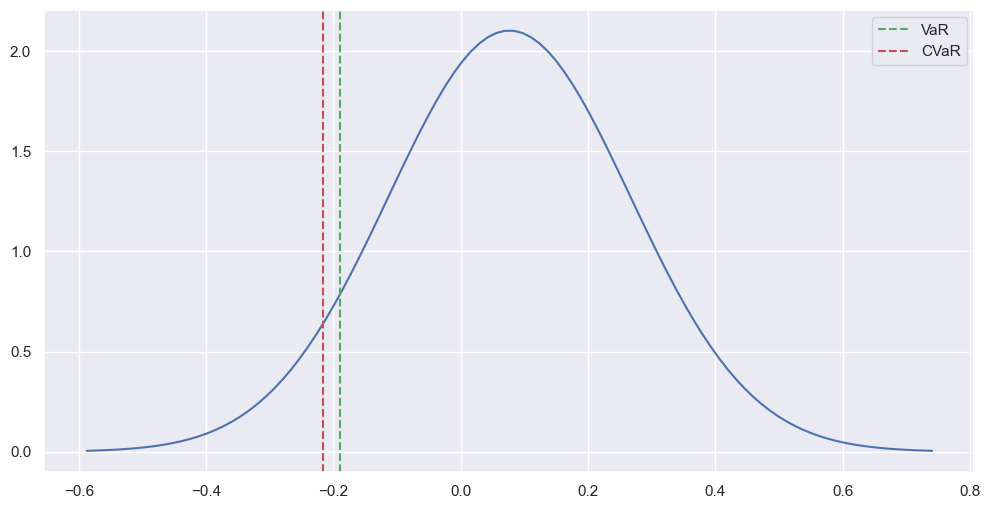

In [ ]:
x = np.linspace(mu - 3.5 * sigma, mu + 3.5 * sigma, 100)
y = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.axvline(SPY_VaR, color='g', linestyle='--', label='VaR')
plt.axvline(SPY_CVaR, color='r', linestyle='--', label='CVaR')
plt.legend()
plt.show()

### Q2. 그렇다면, 여러 주식을 동시에 분석하고 싶으면 어떡하죠?
- 분명 종목간 상관성은 존재할 것입니다. 설령 존재하지 않는다고 하더라도, 우리가 알 수 있는 것은 아닙니다. 먼저 증명한 다음, 혹은 상관성을 제거한 다음 진행해야 할텐데,, 어떻게 해야할까요?

    - 촐레스키 분해는 어떤 행렬을 하삼각행렬과 그 전치행렬의 곱으로 분해하는 방법입니다.
    - 다시 말해, 어떤 실수 대칭 행렬이 양의 정부호일 때, 이 행렬을 하삼각행렬과 그 전치행렬의 곱으로 분해할 수 있습니다.
    - 이 분해 방법은 선형대수학에서의 계산을 간단히 할 수 있게 해주며, 특히 통계학에서는 다변량 정규분포의 샘플을 생성하는 데 사용됩니다.

In [94]:
# 다수의 종목을 대상으로 진행해 봅시다.
rtns = data.pct_change().dropna()

# 주식의 마지막 가격을 가져옵니다.
S_0 = data.iloc[-1]

# 평균, 표준편차 계산
mu, sigma = rtns.mean() * 252, rtns.std() * np.sqrt(252)

# 상관계수 계산
corr = rtns.corr()

# 춀레스키 분해
L = np.linalg.cholesky(corr)

# 시뮬레이션 기간 1년
T = 1

# 시뮬레이션 횟수
Nsimulation = 10000

# VaR
delta = 0.01

# 현재 포트폴리오 가치
pfv_present = np.sum(S_0)
print(f"현재 가치: {pfv_present.round(2)}$")

현재 가치: 1548.0$


In [95]:
# 확인과정
corr

,AGG,GLD,IWM,QQQ,SPY,VNQ,VOO,VTI,XLF,XLK
AGG,1.000000,0.316545,-0.254828,-0.206291,-0.257902,0.065962,-0.256807,-0.256423,-0.351260,-0.205120
GLD,0.316545,1.000000,-0.019710,-0.043475,-0.034048,0.071669,-0.034285,-0.029754,-0.112157,-0.041232
IWM,-0.254828,-0.019710,1.000000,0.826877,0.898659,0.669723,0.898229,0.925253,0.839285,0.805307
QQQ,-0.206291,-0.043475,0.826877,1.000000,0.923324,0.572887,0.923410,0.921502,0.741985,0.971250
SPY,-0.257902,-0.034048,0.898659,0.923324,1.000000,0.684918,0.998246,0.995968,0.890530,0.915327
VNQ,0.065962,0.071669,0.669723,0.572887,0.684918,1.000000,0.684939,0.695174,0.615802,0.560689
VOO,-0.256807,-0.034285,0.898229,0.923410,0.998246,0.684939,1.000000,0.995730,0.889756,0.915365
VTI,-0.256423,-0.029754,0.925253,0.921502,0.995968,0.695174,0.995730,1.000000,0.891765,0.910229
XLF,-0.351260,-0.112157,0.839285,0.741985,0.890530,0.615802,0.889756,0.891765,1.000000,0.740710
XLK,-0.205120,-0.041232,0.805307,0.971250,0.915327,0.560689,0.915365,0.910229,0.740710,1.000000


In [96]:
pd.DataFrame(L@L.T)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.316545,-0.254828,-0.206291,-0.257902,0.065962,-0.256807,-0.256423,-0.351260,-0.205120
1,0.316545,1.000000,-0.019710,-0.043475,-0.034048,0.071669,-0.034285,-0.029754,-0.112157,-0.041232
2,-0.254828,-0.019710,1.000000,0.826877,0.898659,0.669723,0.898229,0.925253,0.839285,0.805307
3,-0.206291,-0.043475,0.826877,1.000000,0.923324,0.572887,0.923410,0.921502,0.741985,0.971250
4,-0.257902,-0.034048,0.898659,0.923324,1.000000,0.684918,0.998246,0.995968,0.890530,0.915327
5,0.065962,0.071669,0.669723,0.572887,0.684918,1.000000,0.684939,0.695174,0.615802,0.560689
6,-0.256807,-0.034285,0.898229,0.923410,0.998246,0.684939,1.000000,0.995730,0.889756,0.915365
7,-0.256423,-0.029754,0.925253,0.921502,0.995968,0.695174,0.995730,1.000000,0.891765,0.910229
8,-0.351260,-0.112157,0.839285,0.741985,0.890530,0.615802,0.889756,0.891765,1.000000,0.740710
9,-0.205120,-0.041232,0.805307,0.971250,0.915327,0.560689,0.915365,0.910229,0.740710,1.000000


In [97]:
# == 써서 확인하면 안나오는데, 이는 아래의 문제와 같다.
# 일일이 손으로 풀면 같을 것.
1.1 + 0.1

1.2000000000000002

In [98]:
# 난수 생성
Z = np.matmul(L, norm.rvs(size=[len(data.columns), Nsimulation]))

# 미래 가격 시뮬레이션
S_T_ = S_T(np.array(S_0).reshape(len(S_0), 1), 0, np.array(sigma).reshape(len(sigma), 1), Z, T)

# 시뮬레이션 후 포트폴리오
pfv_future = np.sum(S_T_, axis=0)

# 수익률
pf_rtns = (pfv_future - pfv_present) / pfv_present
pf_rtns

array([-0.07071941, -0.19466504,  0.37434537, ..., -0.08743012,
       -0.03741164,  0.11102346])

In [99]:
pf_VaR = pd.Series(pf_rtns).quantile(delta)
pf_CVaR = (pf_rtns[pf_rtns <= pf_VaR]).mean()

In [101]:
print(f"VaR: {pf_VaR:.2f}, CVaR: {pf_CVaR:.2f}")

VaR: -0.25, CVaR: -0.29


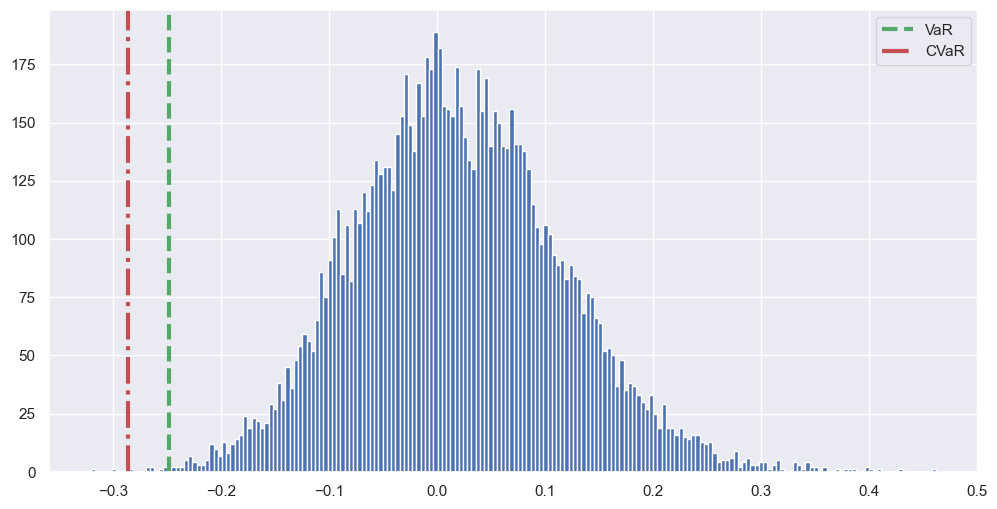

In [102]:
plt.figure(figsize=(12,6))
plt.hist(SPY_rtn, bins = 200)
plt.axvline(pf_VaR, c='g', lw=3, linestyle='--', label = 'VaR')
plt.axvline(pf_CVaR, c='r', lw=3, linestyle='-.', label = 'CVaR')
plt.legend();

# 켈리 방정식 Kelly Criterion

In [595]:
# 확률
pWin = 1/2
pLose = 1-pWin

# 초기 자산
w = 100_000

# 보수
win = 1 # 수익률 
lose = 0.6 # 손실률

# 반복
Niteration = 100

# 기대보수
w * (pWin * (1 + win) + pLose * (1 - lose))

120000.0

In [485]:
# 반복?
gain = []

w * (pWin * (1 + win) + pLose * (1 - lose)) * Niteration

12000000.0

In [618]:
# 경험적으로 살펴봅시다.

# 이겼을 때 내 추가 자산
win_amount = 100_000
# 졌을 때 내 손실 자산
lose_amount = -60_000

# 게임 반복
Niteration = 1000

count_loss = 0
result = []

for _ in range(Niteration):
    if random.random() < pWin:
        result.append(win_amount)
    else:
        result.append(lose_amount)
        count_loss += 1
        
print(f"{Niteration}회 반복했을 때 기대 수익 | {np.sum(result):,.0f}원\n실패 횟수 | {count_loss}회")

1000회 반복했을 때 기대 수익 | 20,000,000원
실패 횟수 | 500회


- 이는 우리 노션에서 봤듯이 고정된 금액만을 배팅한 경우입니다.
- 이제 야수의 심장으로 버는 족족 몰빵 배팅을 해보겠습니다.

142번째 베팅에서 파산했습니다.
나의 자산은 | 0원이 되었습니다.
142게임 중 실패 횟수는 69회 입니다.
승률은 51.75% 입니다.


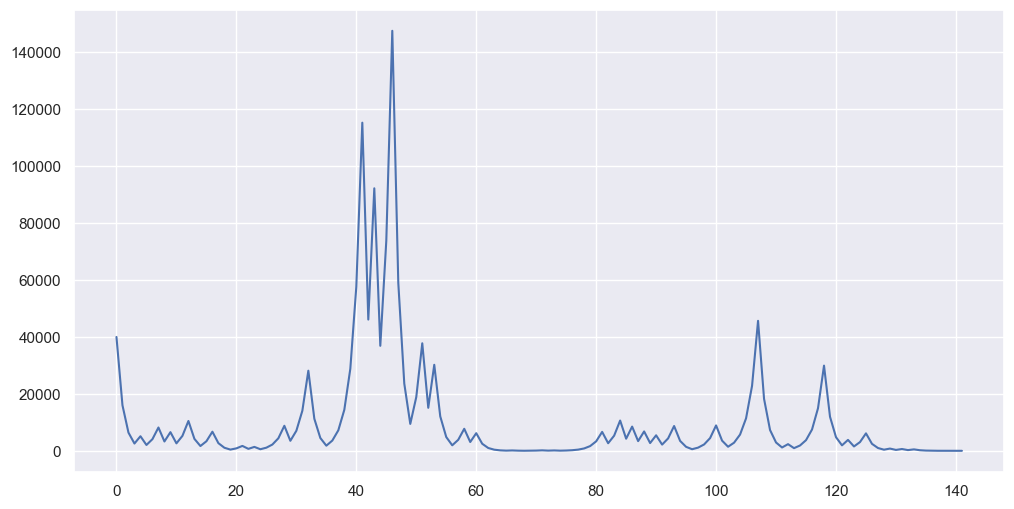

In [636]:
w = 100_000
result = []
Niteration = 1000
count_loss = 0
count = 1

current_money = w

for _ in range(Niteration):
    current_bet = current_money
    
    if random.random() < pWin:
        current_money += current_bet * 1
        count += 1
    else:
        current_money -= current_bet * 0.6
        count_loss += 1
        count += 1

    result.append(current_money)

    if np.round(result[-1]) <= 0:
        print(f"{_+1}번째 베팅에서 파산했습니다.")
        break

# 자산 추적
pd.Series(result).plot(figsize=(12, 6))

# 마지막이 자산의 결과겠죠?
print(f"나의 자산은 | {result[-1]:,.0f}원이 되었습니다.\n{count-1}게임 중 실패 횟수는 {count_loss}회 입니다.")
print(f"승률은 {((count-count_loss)/count) * 100:.2f}% 입니다.")


- 결과가 예상한 대로 나오네요.
- 우리 Kelly Criterion으로 투자 자산의 비율을 찾아보겠습니다.

- 우선, 식은 다음과 같습니다.

$$ f^* = \frac{p}{L} -\frac{q}{W} $$
- $f^\ast$: 최적의 배팅 비율입니다.
- $p$: 배팅에서 이길 확률 입니다.
- $q$: 베팅에서 질 확률 입니다.
- $L$: 게임에서 졌을 때 손실률입니다.
- $W$: 게임에서 이겼을 때 수익률입니다.

- 당연하게도 N번째 게임이 진행되었을 때 기대 수익률을 구할 수 있습니다.

In [633]:
# 위 조건들을 수식에 대입해 보겠습니다.
# 이길 확률, 질 확률 = 0.5, 0.5
# 이겼을 때 수익률 = 100%
# 졌을 때 손실률 = 60%

f_star = (pWin / lose) - (pLose / win)
f_star

0.33333333333333337

나의 자산은 | 23원이 되었습니다.
10게임 중 실패 횟수는 4회 입니다.
승률은 60.00% 입니다.


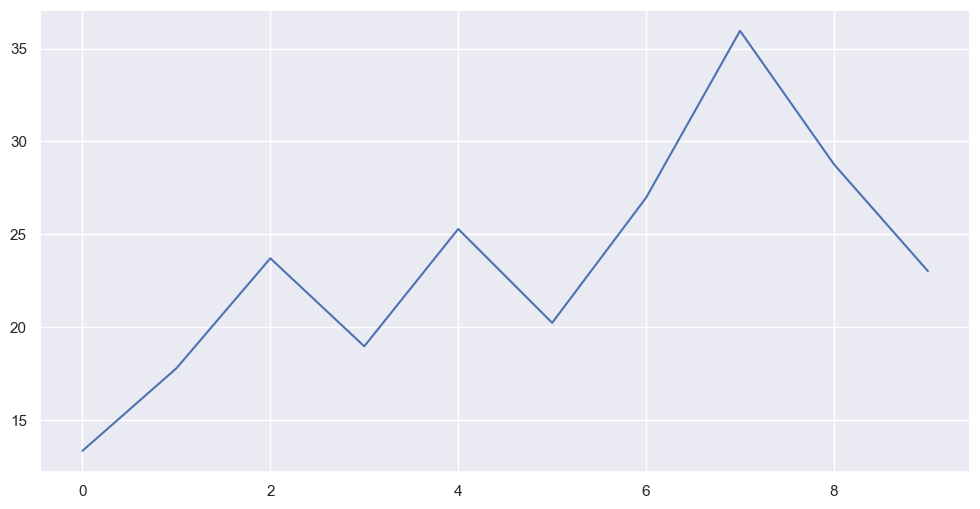

In [642]:
w = 10
result = []
Niteration = 10
count_loss = 0
count = 1

current_money = w

for _ in range(Niteration):
    current_bet = current_money * f_star
    
    if random.random() < pWin:
        current_money += current_bet * win
        count += 1
    else:
        current_money -= current_bet * lose
        count_loss += 1
        count += 1

    result.append(current_money)

    if np.round(result[-1]) <= 0:
        print(f"{_+1}번째 베팅에서 파산했습니다.")
        break

# 자산 추적
pd.Series(result).plot(figsize=(12, 6))

# 마지막이 자산의 결과겠죠?
print(f"나의 자산은 | {result[-1]:,.0f}원이 되었습니다.\n{count-1}게임 중 실패 횟수는 {count_loss}회 입니다.")
print(f"승률은 {((Niteration-count_loss)/Niteration) * 100:.2f}% 입니다.")


- 미쳐버린 결과가 나옵니다.
- 불공정한 게임이라면 어떨까요?

- 예를 들어
    - 이길 확률 : 0.4
    - 질 확률 : 0.6
    - 수익률 : 100%
    - 손실률 : 60%

In [649]:
pWin = 0.4
pLose = 1 - pWin
win = 1.0
lose = 0.6

f_star = (pWin / lose) - (pLose / win) 
print(f"{f_star * 100}% 만 투자하세요.")

6.666666666666677% 만 투자하세요.


나의 자산은 | 126,818원이 되었습니다.
100게임 중 실패 횟수는 59회 입니다.
승률은 41.00% 입니다.


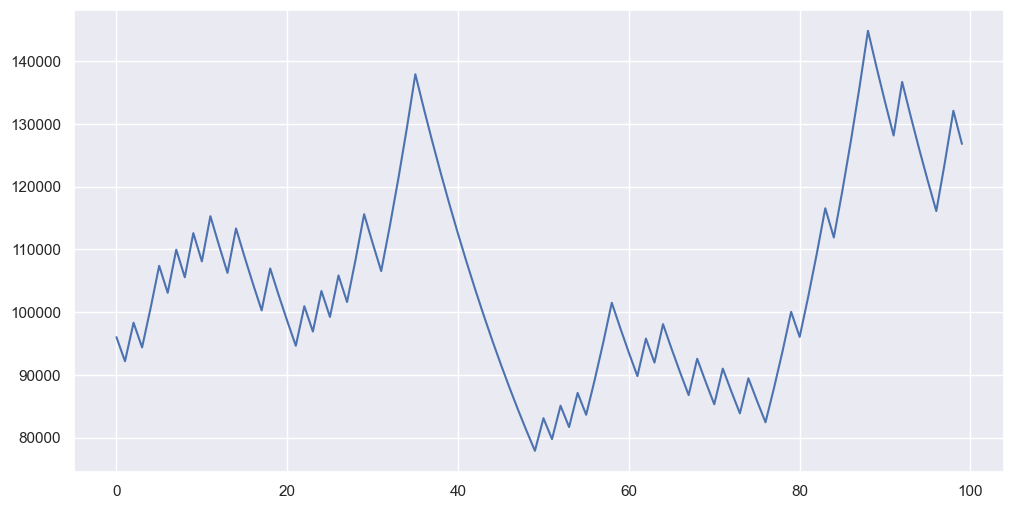

In [652]:
w = 100_000
result = []
Niteration = 100
count_loss = 0
count = 1

current_money = w

for _ in range(Niteration):
    current_bet = current_money * f_star
    
    if random.random() < pWin:
        current_money += current_bet * win
        count += 1
    else:
        current_money -= current_bet * lose
        count_loss += 1
        count += 1

    result.append(current_money)

    if np.round(result[-1]) <= 0:
        print(f"{_+1}번째 베팅에서 파산했습니다.")
        break

# 자산 추적
pd.Series(result).plot(figsize=(12, 6))

# 마지막이 자산의 결과겠죠?
print(f"나의 자산은 | {result[-1]:,.0f}원이 되었습니다.\n{count-1}게임 중 실패 횟수는 {count_loss}회 입니다.")
print(f"승률은 {((Niteration-count_loss)/Niteration) * 100:.2f}% 입니다.")


- 이제 도박에서는 뭐 어떻게 써먹는지 알겠습니다. 근본적으로 이제는 주식에 적용을 해보겠습니다.

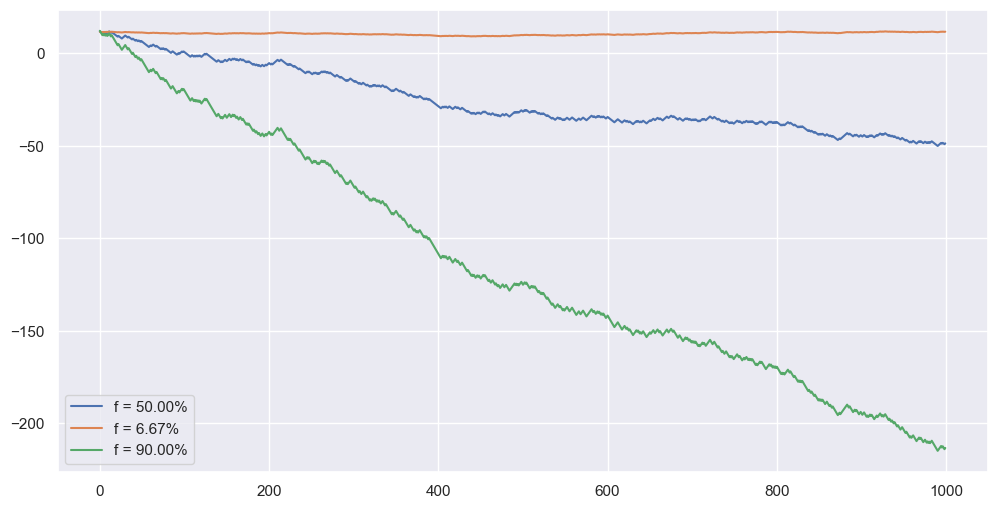

array([ 1. , -0.6, -0.6, -0.6,  1. , -0.6,  1. , -0.6,  1. , -0.6,  1. ,
        1. , -0.6, -0.6,  1. , -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,
        1. , -0.6, -0.6, -0.6, -0.6,  1. ,  1. ,  1. ,  1. , -0.6, -0.6,
       -0.6,  1. , -0.6, -0.6, -0.6, -0.6,  1. , -0.6, -0.6, -0.6,  1. ,
       -0.6, -0.6,  1. , -0.6, -0.6,  1. , -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6,  1. ,  1. , -0.6,  1. ,  1. , -0.6, -0.6,
       -0.6,  1. , -0.6, -0.6, -0.6, -0.6, -0.6,  1. , -0.6,  1. , -0.6,
       -0.6,  1. , -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,  1. ,  1. , -0.6,
       -0.6, -0.6, -0.6, -0.6,  1. ,  1. , -0.6,  1. ,  1. ,  1. , -0.6,
        1. , -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,  1. ,  1. ,
       -0.6, -0.6,  1. , -0.6,  1. , -0.6,  1. , -0.6,  1. , -0.6, -0.6,
        1. ,  1. ,  1. ,  1. , -0.6,  1. , -0.6, -0.6, -0.6, -0.6, -0.6,
       -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,  1. ,  1. , -0.6, -0.6,
       -0.6,  1. , -0.6,  1. ,  1. ,  1. , -0.6, -0

In [656]:
f = np.linspace(0.0, 1.0)
pWin = 0.4
pLose = 1 - pWin
win = 1.0
lose = 0.6
Niteration = 1000

kelly = (pWin/lose) - (pLose/win)

# 이산분포 만들기
p = [pWin, pLose]
values = [win, -lose]
dist = np.random.choice(values, size=Niteration, p=p)

# 로그 수익률 계산
def log_rtns(betting_size, distribution, wealth):
    rec = []
    for i in distribution:
        wealth = (wealth * betting_size) * (1 + i) + wealth * (1-betting_size)
        rec.append(wealth)
    return np.log(np.array(rec))

bet_size = [0.5, kelly, 0.9]
wealth = 100_000

plt.figure(figsize=(12,6))
for i in bet_size:
    rec = log_rtns(i, dist, wealth)
    plt.plot(rec, label=f"f = {i*100:.2f}%")
plt.grid(True)
plt.legend()
plt.show()

dist

- 와, 그림을 보면 그냥 뭐 켈리식 나온대로 투자하면 무조건 먹는거네요? 싶을 수 있습니다.

- 그러나 주식은 조금 다릅니다. 우리는 단순한 도박게임을 하는 것이 아닙니다. 주식은 평균과 분산, 수익률과 손실률 등 모든 데이터가 실시간으로 변합니다. 우리 파라미터를 만져보면서 느낀거지만 켈리 값이 음수가 되는 경우에는 베팅을 하면 안된다는 사실을 알 것입니다.

- 만약에 주식이 움직이다가 켈리값이 음수가 되어버리면.. 끔찍합니다.

- 이걸 해결하기 위해서는 하프 켈리와 수정 켈리라는 방법이 있습니다. 하프 켈리는 켈리의 반만 베팅하는 것입니다.


### 수정 켈리

$$w_p = \frac{\mu_p}{\sigma_p}$$

- 우선은 변동성 대비 기대 수익률을 산출합니다.

$$w\prime _p= 2 N(w_p) - 1$$

- 그 다음, 가중치를 변환하는 과정을 거칩니다.   
- $N(w_p)$는 계산된 포트폴리오의 가중치 $w_p$의 CDF를 나타냅니다.
    - -1 ~ 1 까지의 범위를 가지도록 매핑합니다.

$$N(\cdot) : CDF $$
- $N(w_p)$는 가중치 $w_p$보다 작거나 같은 가중치 값을 가질 확률을 나타냅니다..

- 예를 들어 $N(w_p)$가 60%라면, 0.6 * 2 - 1을 거쳐 1.2가 나옵니다. 즉, 20%만 베팅에 사용하라는 뜻입니다.

- 위 방법을 사용하면 과거의 데이터로 수익률과 변동성을 추정하게 됩니다. (1번식)
- 그렇다는건.. 좋은 $w_p$값이 나오면 더 많은 비중을 투자하라는 것이고, 반대면 또 반대겠네요.

In [665]:
# 미국의 10대 ETF 데이터 불러오기
tickers =['SPY', 'QQQ', 'VOO', 'IWM', 'VTI', 'GLD', 'AGG', 'XLF', 'XLK', 'VNQ']
#tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "BRK-A", "V", "JNJ", "WMT", "PG"]
#tickers = ['GME', 'TLSA']
raw = yf.Tickers(tickers)
data = raw.history(start="2000-01-01", end="2019-12-31").Close
data.head()

[*********************100%***********************]  10 of 10 completed


,AGG,GLD,IWM,QQQ,SPY,VNQ,VOO,VTI,XLF,XLK
Date,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,81.233704,94.595070,NaN,NaN,NaN,11.589033,42.028286
2000-01-04,NaN,NaN,NaN,75.660965,90.895821,NaN,NaN,NaN,11.082399,39.896091
2000-01-05,NaN,NaN,NaN,73.731934,91.058426,NaN,NaN,NaN,10.995329,39.303806
2000-01-06,NaN,NaN,NaN,68.668228,89.595009,NaN,NaN,NaN,11.478201,38.000782
2000-01-07,NaN,NaN,NaN,77.161316,94.798317,NaN,NaN,NaN,11.668189,38.664146


In [666]:
rtns = data.pct_change().dropna()

pf_rtns = rtns.mean(axis=1)
pf_rtns

Date
2010-09-10    0.002713
2010-09-13    0.013171
2010-09-14    0.001385
2010-09-15    0.003755
2010-09-16   -0.000168
                ...   
2019-12-23    0.000567
2019-12-24    0.001898
2019-12-26    0.005022
2019-12-27   -0.000548
2019-12-30   -0.003112
Length: 2342, dtype: float64

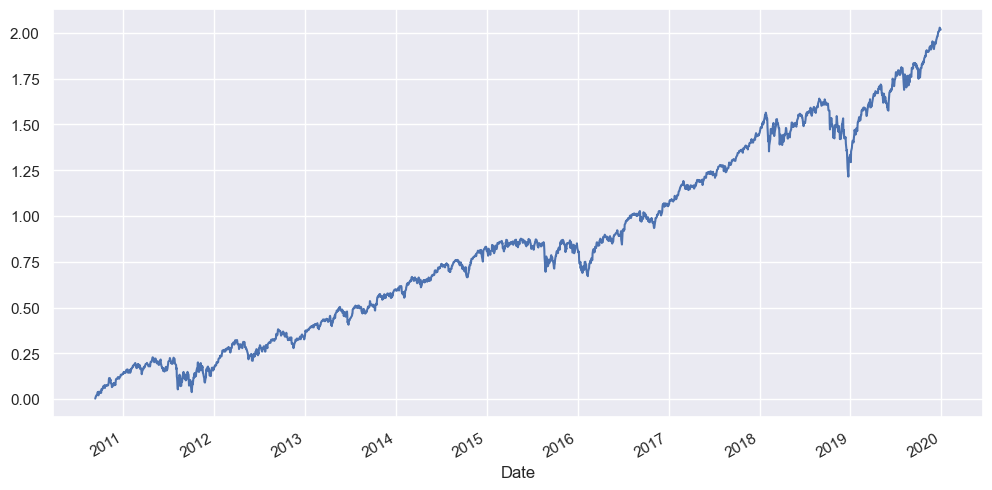

In [667]:
# 포트폴리오 수익의 누적 곱
((1 + pf_rtns).cumprod() - 1).plot(figsize=(12,6));

- 여기에 수정 켈리 적용

In [680]:
#from scipy.stats import norm

lookback = 252

# 1년 롤링 샤프 비율 계산
sharpe_ratio = (pf_rtns.rolling(lookback).mean() / pf_rtns.rolling(lookback).std()) * np.sqrt(252)

# 수식을 옮겨와 봅시다.
kl_weights = pd.Series(2 * norm.cdf(sharpe_ratio) - 1, index=pf_rtns.index).fillna(0)

# Long-Only
kl_weights[kl_weights < 0] = 0

In [681]:
# 켈리 베팅 포트폴리오 수익률
kl_rtns = (pf_rtns * kl_weights.shift()).fillna(0)
kl_crtns = (1 + kl_rtns).cumprod() - 1

In [682]:
kl_crtns

Date
2010-09-10    0.000000
2010-09-13    0.000000
2010-09-14    0.000000
2010-09-15    0.000000
2010-09-16    0.000000
                ...   
2019-12-23    0.576176
2019-12-24    0.579146
2019-12-26    0.587049
2019-12-27    0.586184
2019-12-30    0.581279
Length: 2342, dtype: float64

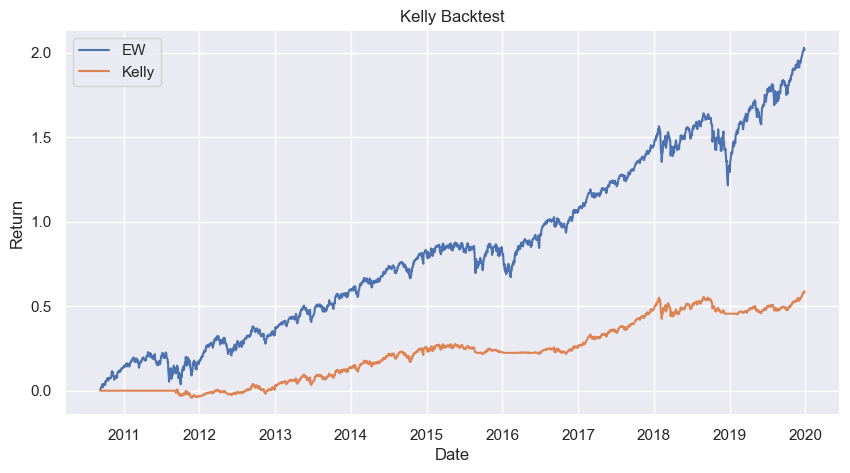

In [685]:
plt.figure(figsize=(10, 5))
plt.plot((1 + pf_rtns).cumprod() - 1, label='EW')
plt.plot(kl_crtns, label='Kelly')
plt.title('Kelly Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()


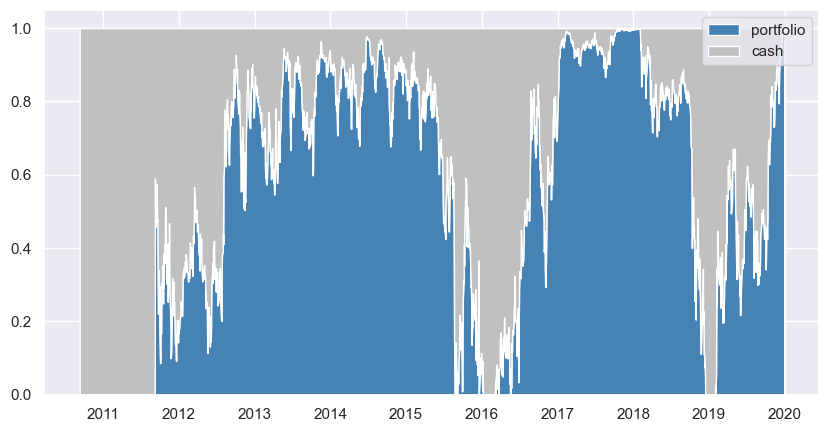

In [688]:
kl_weights_df = pd.concat([kl_weights, 1 - kl_weights], axis=1)
kl_weights_df.columns = ['portfolio', 'cash']
plt.figure(figsize=(10, 5))
plt.stackplot(kl_weights_df.index, kl_weights_df.T, labels=kl_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend();

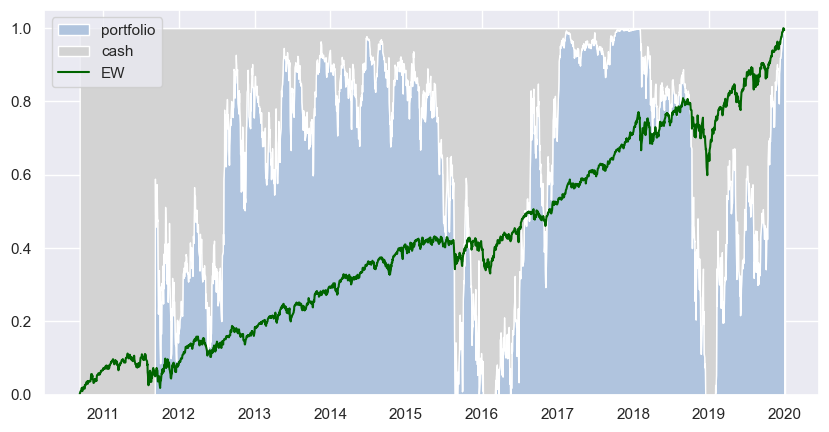

In [689]:
plt.figure(figsize=(10, 5))
plt.stackplot(kl_weights_df.index, kl_weights_df.T, labels=kl_weights_df.columns, colors=['lightsteelblue', 'lightgray'])
plt.plot(((1 + pf_rtns).cumprod() - 1) * 1/max((1 + pf_rtns).cumprod() - 1) , label='EW', color = 'darkgreen')
plt.legend();